<a href="https://colab.research.google.com/github/richardtekere09/Image-recognition-methods/blob/main/Hair_Classification_with_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from PIL import Image ,ImageDraw
from google.colab import drive
drive.mount('/content/drive')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.transforms import v2

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda


Data Loading

In [4]:
def download_data(path_dataset):
    data = []
    y_train = []

    for path_dir in sorted(os.listdir(path=path_dataset)):
        path = path_dataset + path_dir + '/'

        for path_image in sorted(os.listdir(path=path)):
            image = Image.open(path + path_image).resize((180, 180))
            image = np.array(image)

            if len(image.shape) == 2:
                image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
            else:
                image = image[:, :, :3]

            data.append(image.astype(np.uint8))

            if 'Wavy' in path_dir:
                y_train.append(0)
            elif 'Straight' in path_dir:
                y_train.append(1)
            elif 'Dread' in path_dir:
                y_train.append(2)

    return np.array(data), np.array(y_train)

print("✅ Data loading function created!")

✅ Data loading function created!


Load the Dataset

In [5]:
train_images , y_train =download_data('/content/drive/MyDrive/hair/Train/')
test_images , y_test =download_data('/content/drive/MyDrive/hair/Test/')

print(f'Training samples:{len(train_images)}')
print(f'Testing samples:{len(test_images)}')
print(f'Image Shape:{train_images[0].shape}')
print(f"Label distribution in training:")
print(f"  Wavy (0): {np.sum(y_train == 0)}")
print(f"  Straight (1): {np.sum(y_train == 1)}")
print(f"  Dread (2): {np.sum(y_train == 2)}")

Training samples:1051
Testing samples:210
Image Shape:(180, 180, 3)
Label distribution in training:
  Wavy (0): 280
  Straight (1): 408
  Dread (2): 363


Visualize the Dataset

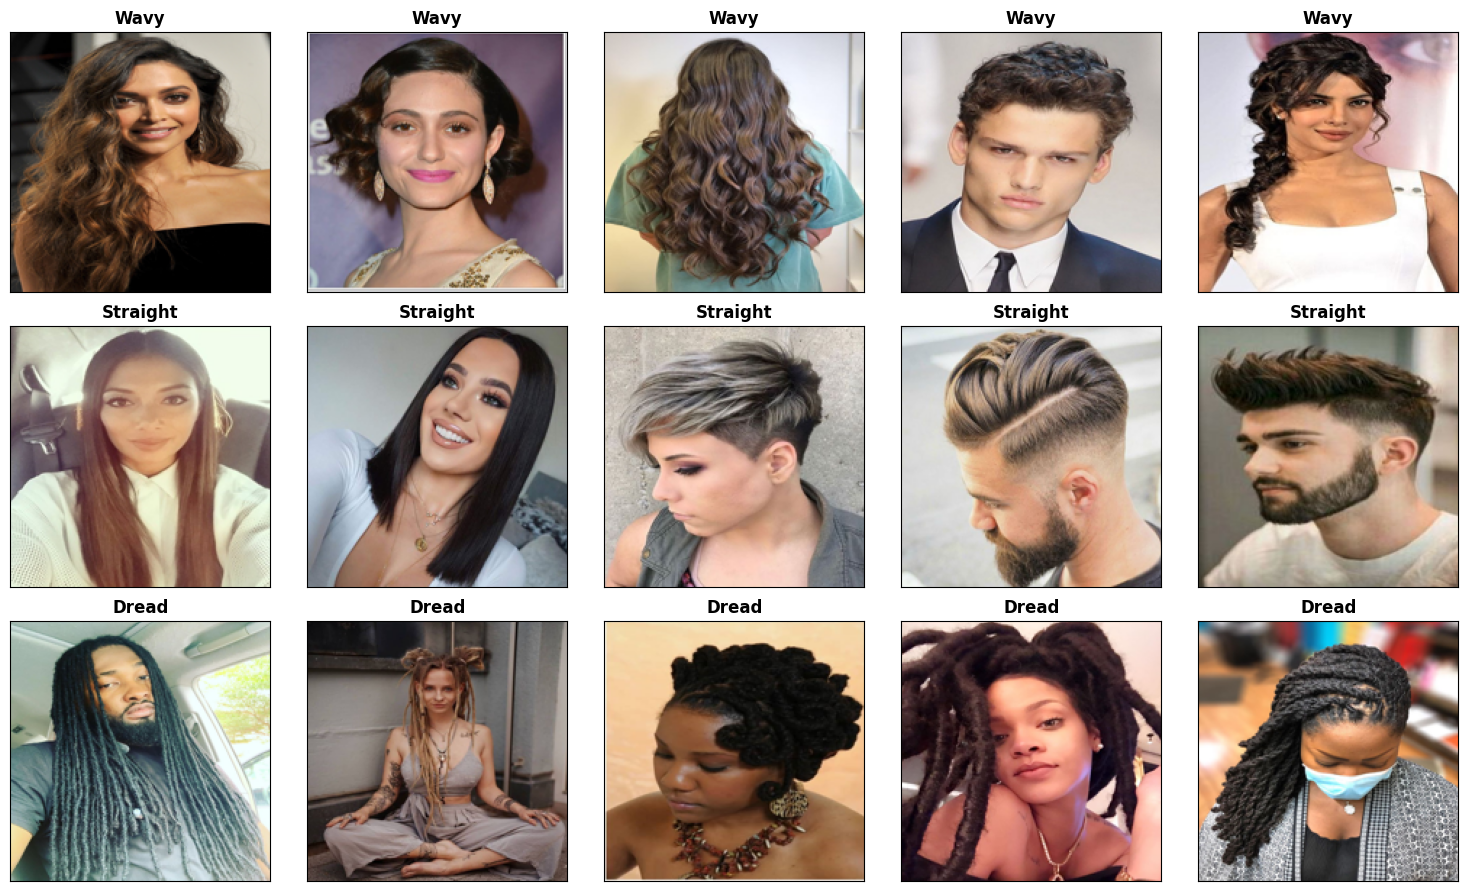

In [6]:
def plot_images_by_class(images, labels, num_images=5):
    """Display sample images from each class"""
    class_names = {0: 'Wavy', 1: 'Straight', 2: 'Dread'}

    plt.figure(figsize=(15, 9))

    for class_id in range(3):
        # Get images from this class
        class_images = images[labels == class_id][:num_images]

        for i in range(len(class_images)):
            plt.subplot(3, num_images, class_id * num_images + i + 1)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(class_images[i])
            plt.title(class_names[class_id], fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.show()

# Display sample images
plot_images_by_class(train_images, y_train, num_images=5)

Create PyTorch Dataset Class

In [7]:
class HairDataset(Dataset):
    """
    Custom PyTorch Dataset for Hair images
    """
    def __init__(self, images, labels, transform=None):
        """
        Parameters:
        - images: numpy array of images
        - labels: numpy array of labels (0, 1, or 2)
        - transform: torchvision transforms to apply
        """
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        """Return the total number of samples"""
        return len(self.images)

    def __getitem__(self, idx):
        """
        Get a single sample

        Returns:
        - image: transformed image tensor
        - label: integer label (0, 1, or 2)
        """
        # ✅ FIX: Get image and label FIRST
        img = self.images[idx]  # Changed from 'image' to 'img'
        label = self.labels[idx]

        # Convert numpy array to PIL Image (required for transforms)
        img = Image.fromarray(img)

        # Apply transformations if provided
        if self.transform:
            img = self.transform(img)

        return img, label

print("✅ Fixed HairDataset class created!")

✅ Fixed HairDataset class created!


Define Data Transforms

In [8]:
basic_transform=transforms.Compose([
    transforms.ToTensor(),
])

augmented_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Adjust brightness/contrast
    transforms.ToTensor(),
])
print("✅ Transforms created!")
print("📌 Basic transform: Only rescaling [0, 255] → [0, 1]")
print("📌 Augmented transform: Flip + Rotation + Color adjustment + Rescaling")

✅ Transforms created!
📌 Basic transform: Only rescaling [0, 255] → [0, 1]
📌 Augmented transform: Flip + Rotation + Color adjustment + Rescaling


Create DataLoaders

In [9]:
train_dataset=HairDataset(train_images,y_train,transform=basic_transform)
test_dataset=HairDataset(test_images,y_test,transform=basic_transform)

# Create data loaders
# batch_size=32 means we feed 32 images at a time to the network
train_loader=DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=2
)

test_loader=DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2
)

print("✅ DataLoaders created!")
print(f"📊 Training batches: {len(train_loader)}")
print(f"📊 Test batches: {len(test_loader)}")
print(f"📊 Images per batch: 32")

# Let's verify the data shape
sample_images, sample_labels = next(iter(train_loader))
print(f"\n🔍 Sample batch shape: {sample_images.shape}")  # Should be [32, 3, 180, 180]
print(f"🔍 Sample labels shape: {sample_labels.shape}")    # Should be [32]
print(f"🔍 Pixel value range: [{sample_images.min():.3f}, {sample_images.max():.3f}]")  # Should be [0, 1]

✅ DataLoaders created!
📊 Training batches: 33
📊 Test batches: 7
📊 Images per batch: 32

🔍 Sample batch shape: torch.Size([32, 3, 180, 180])
🔍 Sample labels shape: torch.Size([32])
🔍 Pixel value range: [0.000, 1.000]


Build CNN Model /n

    """
    CNN for Hair Classification
    Architecture: Alternating Conv2D + MaxPooling2D layers (as specified in lab)
    Input: 180x180x3 images (already rescaled to [0,1] by transforms)
    Output: 3 neurons with sigmoid activation
    """

In [10]:
class HairClassifier(nn.Module):
  def __init__(self,num_classes=3):
      super(HairClassifier, self).__init__()

      # Block 1: Conv2D + ReLU + MaxPooling2D
      self.conv1=nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,padding=1)
      self.relu1=nn.ReLU()
      self.maxpool1=nn.MaxPool2d(kernel_size=2,stride=2)

      # Block 2: Conv2D + ReLU + MaxPooling2D
      self.conv2=nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,padding=1)
      self.relu2=nn.ReLU()
      self.maxpool2=nn.MaxPool2d(kernel_size=2,stride=2)

      # Block 3: Conv2D + ReLU + MaxPooling2D
      self.conv3=nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding=1)
      self.relu3=nn.ReLU()
      self.maxpool3=nn.MaxPool2d(kernel_size=2,stride=2)

      #FLATTEN 2D Tensor to 1D Tensor
      self.flatten=nn.Flatten()

      # Fully connected layers
      # After 3 pooling layers: 180 → 90 → 45 → 22
      # Output size: 128 * 22 * 22 = 61,952
      self.fc1=nn.Linear(128 * 22 * 22, 128)
      self.relu4=nn.ReLU()
      self.dropout = nn.Dropout(0.3)

      # Output layer: 3 neurons with SIGMOID (as specified in lab)
      self.fc2 = nn.Linear(128, num_classes)
        # Note: We'll apply sigmoid in the loss function, not here

  def forward(self,x):
    """
        Forward pass
        x: input tensor of shape [batch_size, 3, 180, 180]
     """
    #Block 1
    x=self.conv1(x)
    x=self.relu1(x)
    x=self.maxpool1(x)

    #Block 2
    x=self.conv2(x)
    x=self.relu2(x)
    x=self.maxpool2(x)

    #Block 3
    x=self.conv3(x)
    x=self.relu3(x)
    x=self.maxpool3(x)

    x=self.flatten(x) # [B, 128*22*22] = [B, 61952]

    # Fully connected
    x=self.fc1(x) # [B, 128]
    x=self.relu4(x)
    x=self.dropout(x)
    x=self.fc2(x) # [B, 3]

    return x

# Create model and move to device (GPU or CPU)
model = HairClassifier(num_classes=3).to(device)

print("✅ Model created and moved to", device)
print("\n" + "="*60)
print("MODEL ARCHITECTURE")
print("="*60)
print(model)
print("="*60)

# Count parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\n📊 Total trainable parameters: {total_params:,}")


✅ Model created and moved to cuda

MODEL ARCHITECTURE
HairClassifier(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=61952, out_features=128, bias=True)
  (relu4): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)

📊 Total trainable parameters: 8,023,619


Loss Function & Optimizer

In [11]:
 # The lab specifies MSE loss, but for classification, we need to be careful
# The lab uses sigmoid output, so we'll use BCEWithLogitsLoss (more stable)
# This combines sigmoid + BCE loss in one step

# IMPORTANT: The lab says "MSE" but for classification with sigmoid output,
# Binary Cross Entropy is more appropriate. However, to follow the lab exactly:

# Option 1: Follow lab exactly (MSE with manual sigmoid)#
#criterion = nn.MSELoss()

# We'll need to convert labels to one-hot encoding for MSE
def labels_to_onehot(labels, num_classes=3):
    """Convert class indices to one-hot vectors"""
    batch_size = labels.size(0)
    one_hot = torch.zeros(batch_size, num_classes, device=labels.device)
    one_hot.scatter_(1, labels.unsqueeze(1), 1)
    return one_hot

# Option 2: Better practice (CrossEntropyLoss - includes softmax)
criterion = nn.CrossEntropyLoss()  # Uncomment this for better results

# Optimizer: Adam (as specified in lab)
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("✅ Optimizer: Adam with learning rate 0.001")
print("   CrossEntropyLoss typically works better, but we follow the lab specs.")

✅ Optimizer: Adam with learning rate 0.001
   CrossEntropyLoss typically works better, but we follow the lab specs.


Training Function


In [12]:
def train_one_epoch(model, train_loader, criterion, optimizer, device):

    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (images, labels) in enumerate(train_loader):
        # Move data to device
        images = images.to(device)
        labels = labels.to(device)

        # Zero the gradient from previous batches
        optimizer.zero_grad()

        # Forward pass
        output = model(images)  # [batch_size, 3] raw logits

        # Apply sigmoid to get probabilities (for MSE loss)
        #outputs_sigmoid = torch.sigmoid(output)
        loss = criterion(output, labels)

        # Convert labels to one-hot for MSE loss
        #labels_onehot = labels_to_onehot(labels, num_classes=3)

        # Calculate loss
        #loss = criterion(outputs_sigmoid, labels_onehot)

        # Backward pass
        loss.backward()  # Compute gradients

        # Update weights
        optimizer.step()

        # Calculate accuracy
        _, predicted = torch.max(output, 1)
        #_, predicted = torch.max(outputs_sigmoid, 1)  # Get class with highest probability
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Accumulate loss
        running_loss += loss.item()

        # Print progress every 3 batches
        if (batch_idx + 1) % 3 == 0:
            print(f'  Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

    # Calculate epoch metrics (AFTER the for loop!)
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total

    return epoch_loss, epoch_acc

print("✅ Training function created!")

✅ Training function created!


Validation/Test Function

In [13]:
def evaluate_model(model, test_loader, criterion, device):
  model.eval()
  running_loss=0.0
  correct=0
  total=0

  # No gradient calculation needed for evaluation (saves memory)
  with torch.no_grad():
    for images ,labels in test_loader:
       images=images.to(device)
       labels=labels.to(device)

       output=model(images)
       #outputs_sigmoid=torch.sigmoid(output)

       #labels_onehot=labels_to_onehot(labels,num_classes=3)
       #loss=criterion(outputs_sigmoid,labels_onehot)
       loss=criterion(output,labels)

       #calculate accuracy
       _,predicted=torch.max(output,1)
       total+=labels.size(0)
       correct+=(predicted==labels).sum().item()

       running_loss +=loss.item()

  epoch_loss=running_loss/ len(test_loader)
  epoch_acc = 100 * correct / total
  return epoch_loss, epoch_acc

print("✅ Evaluation function created!")


✅ Evaluation function created!


In [15]:
num_epochs =20
history={
    'train_loss':[],
    'train_acc':[],
    'val_loss':[],
    'val_acc':[]
}

print("="*60)
print("🚀 STARTING TRAINING")
print("="*60)
print(f"📊 Training samples: {len(train_images)}")
print(f"📊 Test samples: {len(test_images)}")
print(f"📊 Epochs: {num_epochs}")
print(f"📊 Batch size: 32")
print(f"📊 Device: {device}")
print("="*60)

# Main training loop
for epoch in range(num_epochs):
  print(f"\n📅 Epoch [{epoch+1}/{num_epochs}]")
  print("-" * 60)

  # Train for one epoch
  train_loss,train_acc=train_one_epoch(
      model,
      train_loader,
      criterion,
      optimizer,
      device
      )

  # Test for one epoch
  val_loss,val_acc= evaluate_model(
      model,
      test_loader,
      criterion,
      device
      )

  history['train_loss'].append(train_loss)
  history['train_acc'].append(train_acc)
  history['val_loss'].append(val_loss)
  history['val_acc'].append(val_acc)

# Print epoch summary
print("-" * 60)
print(f"📈 EPOCH {epoch+1} SUMMARY:")
print(f"   Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
print(f"   Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")
print("-" * 60)

print("\n" + "="*60)
print("✅ TRAINING COMPLETED!")
print("="*60)
print(f"🎯 Final Train Accuracy: {history['train_acc'][-1]:.2f}%")
print(f"🎯 Final Val Accuracy:   {history['val_acc'][-1]:.2f}%")
print("="*60)


🚀 STARTING TRAINING
📊 Training samples: 1051
📊 Test samples: 210
📊 Epochs: 20
📊 Batch size: 32
📊 Device: cuda

📅 Epoch [1/20]
------------------------------------------------------------
  Batch [3/33], Loss: 1.6701
  Batch [6/33], Loss: 1.0852
  Batch [9/33], Loss: 1.0174
  Batch [12/33], Loss: 1.1448
  Batch [15/33], Loss: 1.0877
  Batch [18/33], Loss: 1.0812
  Batch [21/33], Loss: 1.0744
  Batch [24/33], Loss: 1.0643
  Batch [27/33], Loss: 1.0537
  Batch [30/33], Loss: 1.1285
  Batch [33/33], Loss: 1.0799

📅 Epoch [2/20]
------------------------------------------------------------
  Batch [3/33], Loss: 1.0412
  Batch [6/33], Loss: 1.0296
  Batch [9/33], Loss: 1.1303
  Batch [12/33], Loss: 1.0151
  Batch [15/33], Loss: 1.0592
  Batch [18/33], Loss: 1.0169
  Batch [21/33], Loss: 1.0652
  Batch [24/33], Loss: 1.0284
  Batch [27/33], Loss: 0.9335
  Batch [30/33], Loss: 1.0261
  Batch [33/33], Loss: 0.9962

📅 Epoch [3/20]
------------------------------------------------------------
  Bat

Plot Training History

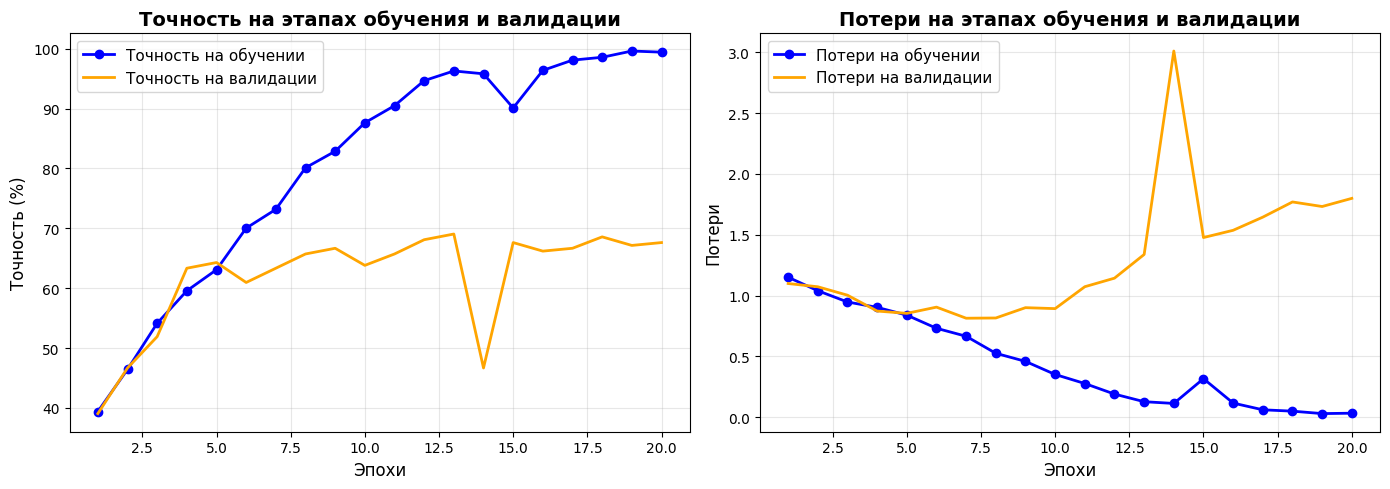


📊 TRAINING STATISTICS
Best Train Accuracy: 99.62% (Epoch 19)
Best Val Accuracy:   69.05% (Epoch 13)
Final Train Loss:    0.0323
Final Val Loss:      1.7993
⚠️  WARNING: Large gap between train and val accuracy!
   Gap: 31.81%
   This indicates overfitting. Consider:
   - Using data augmentation
   - Adding more dropout
   - Reducing model complexity


In [16]:
# Extract data from history
accuracy = history['train_acc']
val_accuracy = history['val_acc']
loss = history['train_loss']
val_loss = history['val_loss']
epochs_range = range(1, len(accuracy) + 1)

# Create figure with 2 subplots (side by side)
plt.figure(figsize=(14, 5))

# Plot 1: Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, 'bo-', label='Точность на обучении', linewidth=2, markersize=6)
plt.plot(epochs_range, val_accuracy, 'orange', label='Точность на валидации', linewidth=2)
plt.title('Точность на этапах обучения и валидации', fontsize=14, fontweight='bold')
plt.xlabel('Эпохи', fontsize=12)
plt.ylabel('Точность (%)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Plot 2: Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, 'bo-', label='Потери на обучении', linewidth=2, markersize=6)
plt.plot(epochs_range, val_loss, 'orange', label='Потери на валидации', linewidth=2)
plt.title('Потери на этапах обучения и валидации', fontsize=14, fontweight='bold')
plt.xlabel('Эпохи', fontsize=12)
plt.ylabel('Потери', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final statistics
print("\n" + "="*60)
print("📊 TRAINING STATISTICS")
print("="*60)
print(f"Best Train Accuracy: {max(accuracy):.2f}% (Epoch {accuracy.index(max(accuracy))+1})")
print(f"Best Val Accuracy:   {max(val_accuracy):.2f}% (Epoch {val_accuracy.index(max(val_accuracy))+1})")
print(f"Final Train Loss:    {loss[-1]:.4f}")
print(f"Final Val Loss:      {val_loss[-1]:.4f}")
print("="*60)

# Check for overfitting
train_val_gap = accuracy[-1] - val_accuracy[-1]
if train_val_gap > 15:
    print("⚠️  WARNING: Large gap between train and val accuracy!")
    print(f"   Gap: {train_val_gap:.2f}%")
    print("   This indicates overfitting. Consider:")
    print("   - Using data augmentation")
    print("   - Adding more dropout")
    print("   - Reducing model complexity")
elif train_val_gap > 10:
    print("⚠️  Moderate overfitting detected (gap: {:.2f}%)".format(train_val_gap))
else:
    print("✅ Good generalization! (gap: {:.2f}%)".format(train_val_gap))
print("="*60)

🔍 MODEL PREDICTIONS ON TEST SET


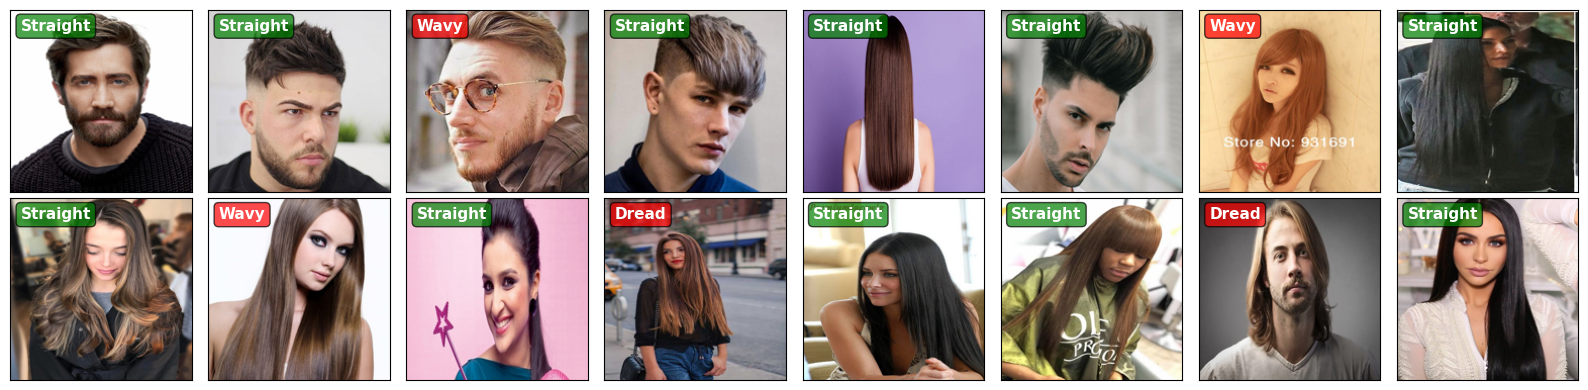


📊 Predictions on 16 images:
   Correct: 11/16
   Accuracy: 68.75%


In [17]:
def visualize_predictions(model, test_dataset, device, start_idx=100, num_images=16):
    """
    Display model predictions on test images
    Following the lab document format
    """
    model.eval()
    class_names = {0: 'Wavy', 1: 'Straight', 2: 'Dread'}

    # Get predictions for a batch of images
    images_list = []
    labels_list = []
    predictions_list = []

    with torch.no_grad():
        for i in range(start_idx, start_idx + num_images):
            if i >= len(test_dataset):
                break

            image, true_label = test_dataset[i]
            images_list.append(image)
            labels_list.append(true_label)

            # Get prediction
            image_batch = image.unsqueeze(0).to(device)
            output = model(image_batch)
            output_sigmoid = torch.sigmoid(output)
            _, predicted = torch.max(output_sigmoid, 1)
            predictions_list.append(predicted.item())

    # Plot results (2 rows, 8 columns like in the lab)
    plt.figure(figsize=(16, 4))

    for i in range(len(images_list)):
        plt.subplot(2, 8, i + 1)

        # Denormalize image for display
        img_display = images_list[i].cpu().numpy().transpose(1, 2, 0)
        img_display = np.clip(img_display, 0, 1)  # Ensure [0, 1] range

        # Display image
        plt.imshow(img_display)

        # Add label with color coding
        predicted_class = predictions_list[i]
        true_class = labels_list[i]
        label_text = class_names[predicted_class]

        # Green if correct, red if wrong
        color = 'green' if predicted_class == true_class else 'red'
        bbox_props = dict(boxstyle='round,pad=0.3', facecolor=color, alpha=0.7)

        plt.text(10, 20, label_text, color='white',
                fontsize=11, fontweight='bold', bbox=bbox_props)

        plt.xticks([])
        plt.yticks([])

    plt.tight_layout()
    plt.show()

    # Print accuracy for this batch
    correct_in_batch = sum([1 for p, t in zip(predictions_list, labels_list) if p == t])
    batch_accuracy = 100 * correct_in_batch / len(predictions_list)
    print(f"\n📊 Predictions on {len(predictions_list)} images:")
    print(f"   Correct: {correct_in_batch}/{len(predictions_list)}")
    print(f"   Accuracy: {batch_accuracy:.2f}%")

# Visualize predictions
print("="*60)
print("🔍 MODEL PREDICTIONS ON TEST SET")
print("="*60)
visualize_predictions(model, test_dataset, device, start_idx=100, num_images=16)

In [18]:
print("="*60)
print("🎨 TASK 6: DATA AUGMENTATION & MODEL IMPROVEMENT")
print("="*60)

# Enhanced augmentation transforms
augmented_transform = transforms.Compose([
    # Geometric transformations
    transforms.RandomHorizontalFlip(p=0.5),           # 50% chance to flip
    transforms.RandomRotation(degrees=20),            # Rotate ±20 degrees
    transforms.RandomAffine(degrees=0,
                           translate=(0.1, 0.1),      # Shift up to 10%
                           scale=(0.9, 1.1)),         # Zoom 90-110%

    # Color augmentations
    transforms.ColorJitter(brightness=0.3,            # Adjust brightness
                          contrast=0.3,               # Adjust contrast
                          saturation=0.3,             # Adjust saturation
                          hue=0.1),                   # Slight hue shift

    # Convert to tensor and normalize
    transforms.ToTensor(),  # Converts to [0, 1] range
])

print("✅ Augmentation pipeline created!")
print("\n📋 Augmentations applied:")
print("   1. Random Horizontal Flip (50%)")
print("   2. Random Rotation (±20°)")
print("   3. Random Translation (±10%)")
print("   4. Random Zoom (90-110%)")
print("   5. Color Jitter (brightness, contrast, saturation)")
print("="*60)

🎨 TASK 6: DATA AUGMENTATION & MODEL IMPROVEMENT
✅ Augmentation pipeline created!

📋 Augmentations applied:
   1. Random Horizontal Flip (50%)
   2. Random Rotation (±20°)
   3. Random Translation (±10%)
   4. Random Zoom (90-110%)
   5. Color Jitter (brightness, contrast, saturation)


🔍 Visualizing augmentation effects on different hair types:



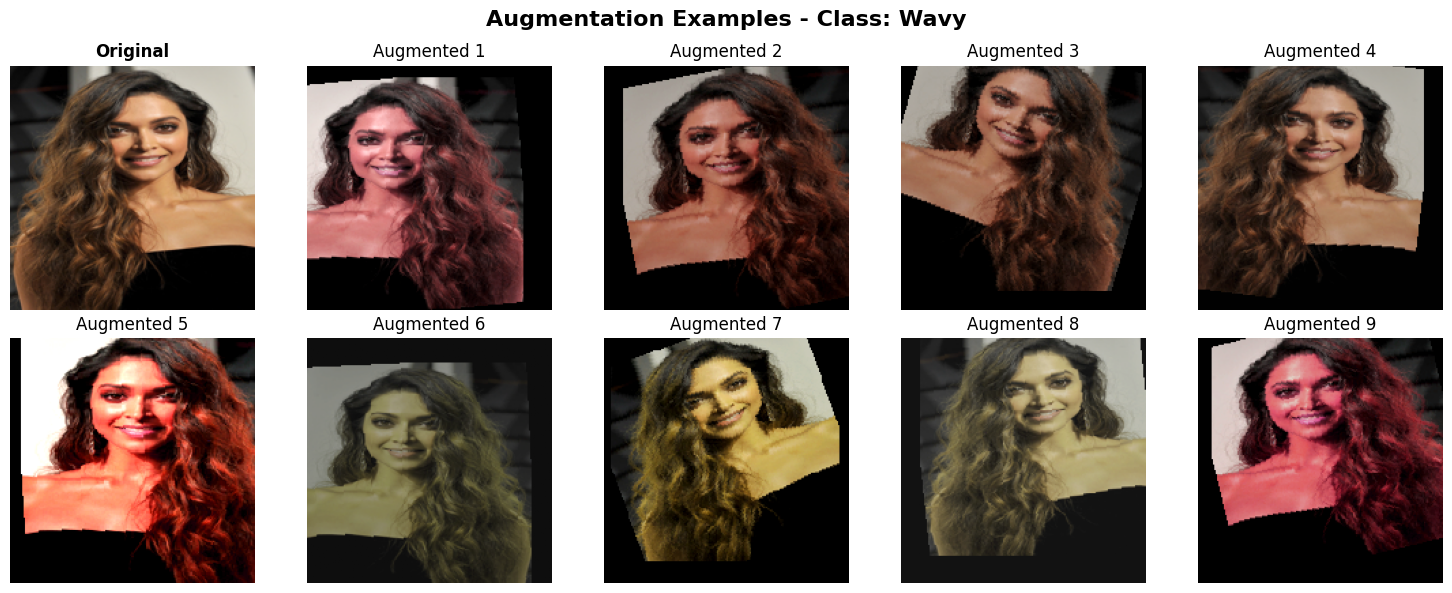

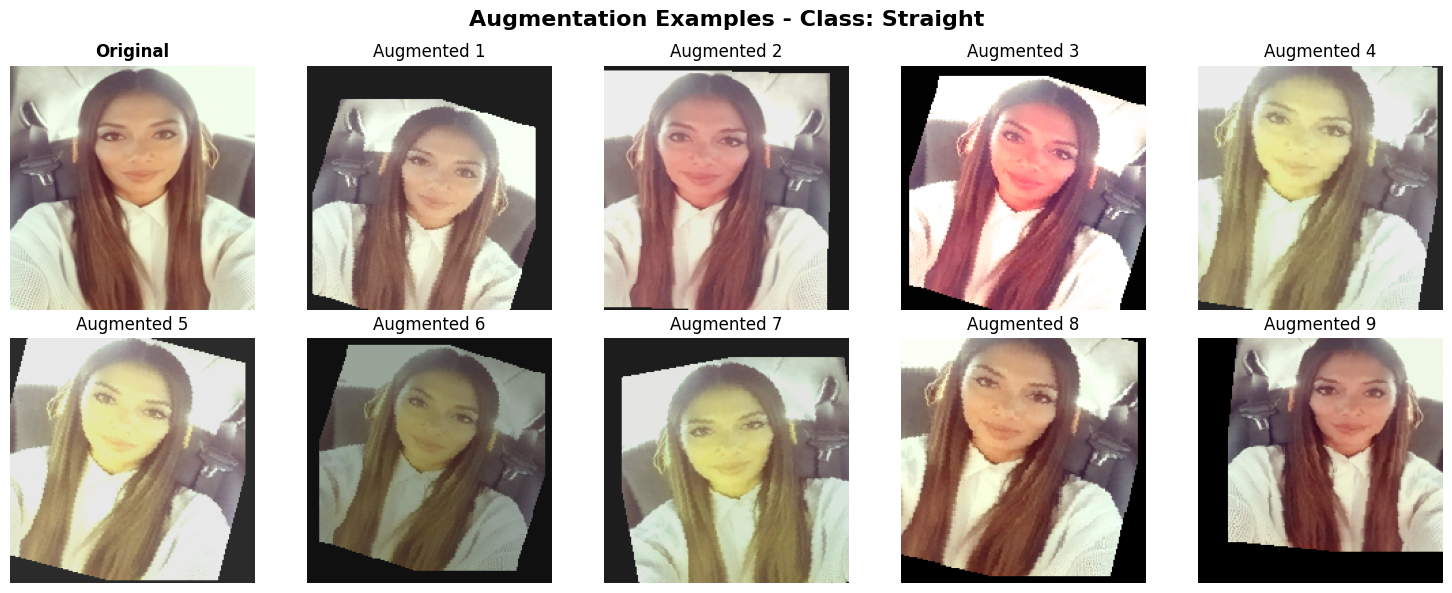

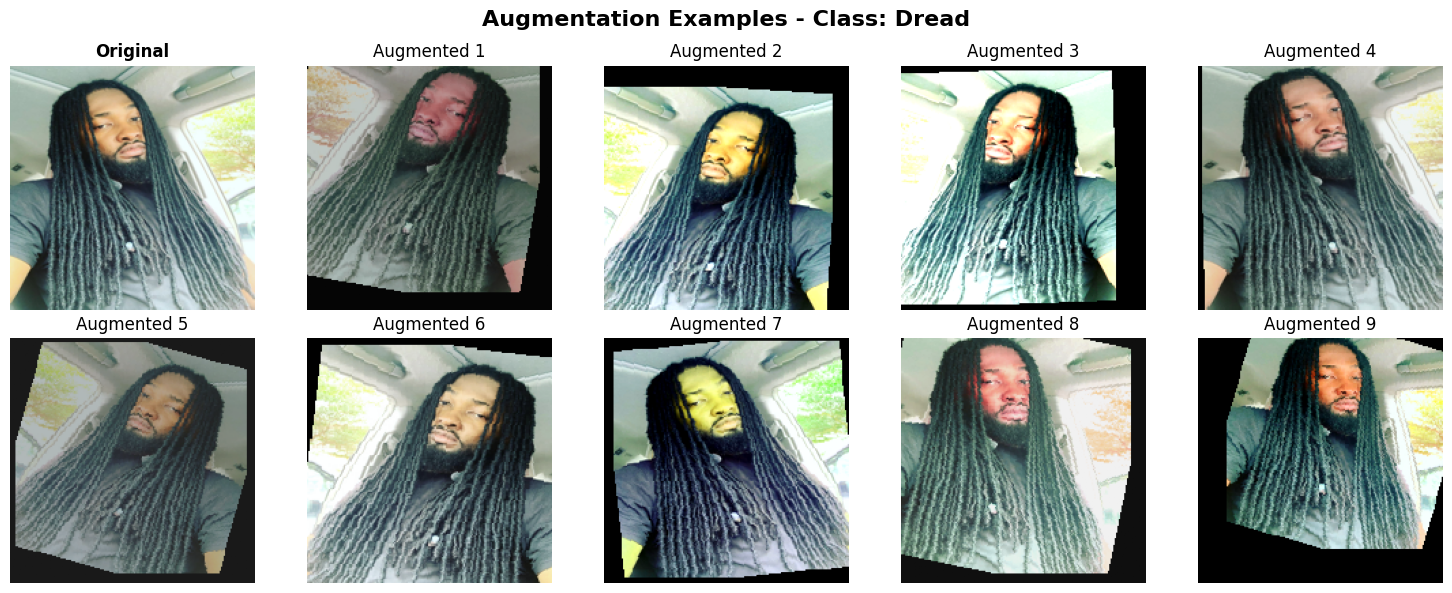

In [19]:
def show_augmentation_examples(dataset, original_transform, augmented_transform, idx=0):
    """
    Show how augmentation transforms the same image
    """
    # Get original image
    original_img = dataset.images[idx]
    label = dataset.labels[idx]
    class_names = {0: 'Wavy', 1: 'Straight', 2: 'Dread'}

    # Create figure
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    fig.suptitle(f'Augmentation Examples - Class: {class_names[label]}',
                 fontsize=16, fontweight='bold')

    # Original image
    axes[0, 0].imshow(original_img)
    axes[0, 0].set_title('Original', fontweight='bold')
    axes[0, 0].axis('off')

    # Show 9 augmented versions
    for i in range(1, 10):
        row = i // 5
        col = i % 5

        # Apply augmentation
        pil_img = Image.fromarray(original_img)
        aug_tensor = augmented_transform(pil_img)
        aug_img = aug_tensor.cpu().numpy().transpose(1, 2, 0)
        aug_img = np.clip(aug_img, 0, 1)

        axes[row, col].imshow(aug_img)
        axes[row, col].set_title(f'Augmented {i}')
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

# Show examples for each class
print("🔍 Visualizing augmentation effects on different hair types:\n")

for class_idx in range(3):
    # Find an image from this class
    sample_idx = np.where(y_train == class_idx)[0][0]
    show_augmentation_examples(
        type('Dataset', (), {'images': train_images, 'labels': y_train})(),
        basic_transform,
        augmented_transform,
        idx=sample_idx
    )
    print()

In [20]:
class ImprovedHairClassifier(nn.Module):
  def __init__(self,num_classes=3):
      super(ImprovedHairClassifier, self).__init__()

      # Block 1: Conv2D + ReLU + MaxPooling2D
      self.conv1=nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,padding=1)
      self.relu1=nn.ReLU()
      self.maxpool1=nn.MaxPool2d(kernel_size=2,stride=2)

      # Block 2: Conv2D + ReLU + MaxPooling2D
      self.conv2=nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,padding=1)
      self.relu2=nn.ReLU()
      self.maxpool2=nn.MaxPool2d(kernel_size=2,stride=2)

      # Block 3: Conv2D + ReLU + MaxPooling2D
      self.conv3=nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding=1)
      self.relu3=nn.ReLU()
      self.maxpool3=nn.MaxPool2d(kernel_size=2,stride=2)

      #FLATTEN 2D Tensor to 1D Tensor
      self.flatten=nn.Flatten()

      # Fully connected layers
      # After 3 pooling layers: 180 → 90 → 45 → 22
      # Output size: 128 * 22 * 22 = 61,952
      self.fc1=nn.Linear(128 * 22 * 22, 128)
      self.relu4=nn.ReLU()
      self.dropout = nn.Dropout(0.3)

      # Output layer: 3 neurons with SIGMOID (as specified in lab)
      self.fc2 = nn.Linear(128, num_classes)
        # Note: We'll apply sigmoid in the loss function, not here

  def forward(self,x):
    """
        Forward pass
        x: input tensor of shape [batch_size, 3, 180, 180]
     """
    #Block 1
    x=self.conv1(x)
    x=self.relu1(x)
    x=self.maxpool1(x)

    #Block 2
    x=self.conv2(x)
    x=self.relu2(x)
    x=self.maxpool2(x)

    #Block 3
    x=self.conv3(x)
    x=self.relu3(x)
    x=self.maxpool3(x)

    x=self.flatten(x) # [B, 128*22*22] = [B, 61952]

    # Fully connected
    x=self.fc1(x) # [B, 128]
    x=self.relu4(x)
    x=self.dropout(x)
    x=self.fc2(x) # [B, 3]

    return x

# Create model and move to device (GPU or CPU)
model_improved = ImprovedHairClassifier(num_classes=3).to(device)

print("✅ Model created and moved to", device)
print("\n" + "="*60)
print("MODEL ARCHITECTURE")
print("="*60)
print(model)
print("="*60)

# Count parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\n📊 Total trainable parameters: {total_params:,}")


✅ Model created and moved to cuda

MODEL ARCHITECTURE
HairClassifier(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=61952, out_features=128, bias=True)
  (relu4): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)

📊 Total trainable parameters: 8,023,619


In [21]:
# Create augmented training dataset (test stays the same)
train_dataset_aug = HairDataset(train_images, y_train, transform=augmented_transform)
test_dataset_basic = HairDataset(test_images, y_test, transform=basic_transform)

# Create data loaders
train_loader_aug = DataLoader(
    train_dataset_aug,
    batch_size=32,
    shuffle=True,
    num_workers=2
)

test_loader_basic = DataLoader(
    test_dataset_basic,
    batch_size=32,
    shuffle=False,
    num_workers=2
)

print("="*60)
print("📦 AUGMENTED DATASETS CREATED")
print("="*60)
print(f"✅ Training: With augmentation ({len(train_dataset_aug)} samples)")
print(f"✅ Testing: Without augmentation ({len(test_dataset_basic)} samples)")
print(f"✅ Batch size: 32")
print("="*60)

📦 AUGMENTED DATASETS CREATED
✅ Training: With augmentation (1051 samples)
✅ Testing: Without augmentation (210 samples)
✅ Batch size: 32


In [22]:
# Use CrossEntropyLoss instead of MSE (better for classification)
criterion_improved = nn.CrossEntropyLoss()
optimizer_improved = optim.Adam(model_improved.parameters(), lr=0.001)

# # Add learning rate scheduler (NEW!)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_improved,
    mode='max',      # Monitor accuracy (maximize)
    factor=0.5,      # Reduce LR by half
    patience=3,      # After 3 epochs without improvement
    #verbose=True
)

# Training history
history_improved = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

# Modified training function for CrossEntropyLoss
def train_one_epoch_improved(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)  # No sigmoid needed with CrossEntropyLoss!
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()

        if (batch_idx + 1) % 3 == 0:
            print(f'  Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

def evaluate_model_improved(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()

    epoch_loss = running_loss / len(test_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

# Training loop
num_epochs_improved = 20  # More epochs since we have augmentation

print("\n" + "="*60)
print("🚀 TRAINING IMPROVED MODEL WITH AUGMENTATION")
print("="*60)
print(f"📊 Epochs: {num_epochs_improved}")
print(f"📊 Loss Function: CrossEntropyLoss (better than MSE)")
print(f"📊 Learning Rate: 0.001 (with scheduler)")
print(f"📊 Augmentation: ENABLED")
print("="*60)

best_val_acc = 0.0
patience_counter = 0

for epoch in range(num_epochs_improved):
    print(f"\n📅 Epoch [{epoch+1}/{num_epochs_improved}]")
    print("-" * 60)

    # Train
    train_loss, train_acc = train_one_epoch_improved(
        model_improved,
        train_loader_aug,
        criterion_improved,
        optimizer_improved,
        device
    )

    # Validate
    val_loss, val_acc = evaluate_model_improved(
        model_improved,
        test_loader_basic,
        criterion_improved,
        device
    )

    # Update learning rate based on validation accuracy
    scheduler.step(val_acc)

    # Store history
    history_improved['train_loss'].append(train_loss)
    history_improved['train_acc'].append(train_acc)
    history_improved['val_loss'].append(val_loss)
    history_improved['val_acc'].append(val_acc)

    # Track best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        # Save best model
        torch.save(model_improved.state_dict(),
                  '/content/drive/My Drive/best_hair_model.pth')
        print(f"   💾 New best model saved! Val Acc: {val_acc:.2f}%")

    # Print summary
    print("-" * 60)
    print(f"📈 EPOCH {epoch+1} SUMMARY:")
    print(f"   Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"   Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")
    print(f"   Best Val Acc: {best_val_acc:.2f}%")
    print("-" * 60)

print("\n" + "="*60)
print("✅ TRAINING COMPLETED!")
print("="*60)
print(f"🎯 Best Validation Accuracy: {best_val_acc:.2f}%")
print(f"🎯 Final Train Accuracy: {history_improved['train_acc'][-1]:.2f}%")
print(f"🎯 Final Val Accuracy: {history_improved['val_acc'][-1]:.2f}%")
print("="*60)


🚀 TRAINING IMPROVED MODEL WITH AUGMENTATION
📊 Epochs: 20
📊 Loss Function: CrossEntropyLoss (better than MSE)
📊 Learning Rate: 0.001 (with scheduler)
📊 Augmentation: ENABLED

📅 Epoch [1/20]
------------------------------------------------------------
  Batch [3/33], Loss: 1.1084
  Batch [6/33], Loss: 1.1223
  Batch [9/33], Loss: 1.1539
  Batch [12/33], Loss: 1.0960
  Batch [15/33], Loss: 1.0948
  Batch [18/33], Loss: 1.0769
  Batch [21/33], Loss: 1.0772
  Batch [24/33], Loss: 1.0931
  Batch [27/33], Loss: 1.1352
  Batch [30/33], Loss: 1.0244
  Batch [33/33], Loss: 1.0572
   💾 New best model saved! Val Acc: 45.71%
------------------------------------------------------------
📈 EPOCH 1 SUMMARY:
   Train Loss: 1.0962 | Train Acc: 38.06%
   Val Loss:   1.0904 | Val Acc:   45.71%
   Best Val Acc: 45.71%
------------------------------------------------------------

📅 Epoch [2/20]
------------------------------------------------------------
  Batch [3/33], Loss: 1.0703
  Batch [6/33], Loss: 1.

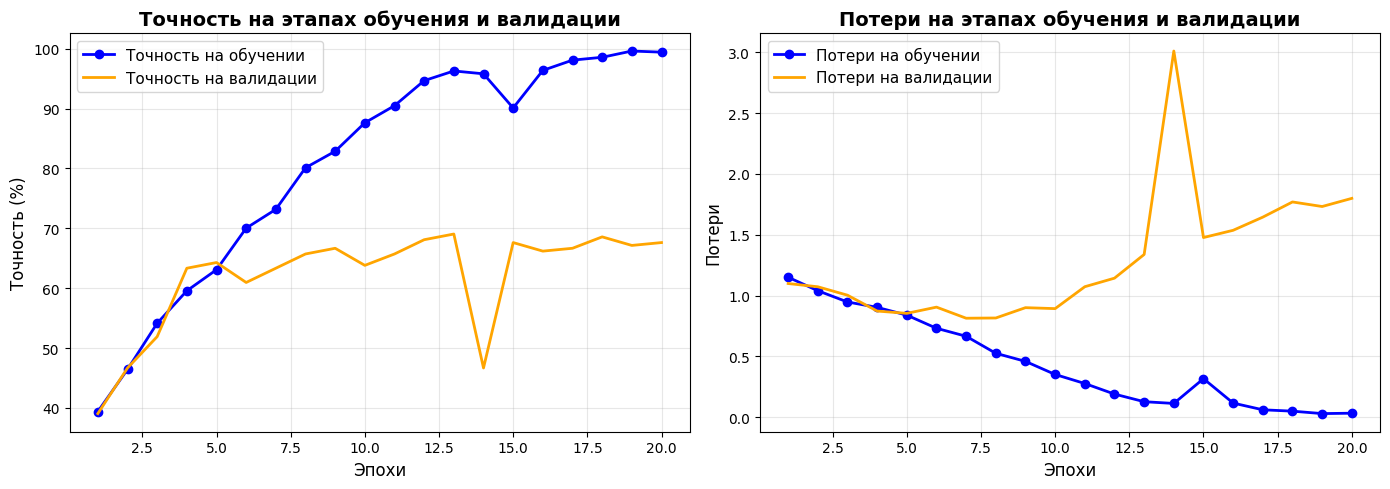


📊 TRAINING STATISTICS
Best Train Accuracy: 99.62% (Epoch 19)
Best Val Accuracy:   69.05% (Epoch 13)
Final Train Loss:    0.0323
Final Val Loss:      1.7993
⚠️  WARNING: Large gap between train and val accuracy!
   Gap: 31.81%
   This indicates overfitting. Consider:
   - Using data augmentation
   - Adding more dropout
   - Reducing model complexity


In [23]:
# Extract data from history
accuracy = history['train_acc']
val_accuracy = history['val_acc']
loss = history['train_loss']
val_loss = history['val_loss']
epochs_range = range(1, len(accuracy) + 1)

# Create figure with 2 subplots (side by side)
plt.figure(figsize=(14, 5))

# Plot 1: Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, 'bo-', label='Точность на обучении', linewidth=2, markersize=6)
plt.plot(epochs_range, val_accuracy, 'orange', label='Точность на валидации', linewidth=2)
plt.title('Точность на этапах обучения и валидации', fontsize=14, fontweight='bold')
plt.xlabel('Эпохи', fontsize=12)
plt.ylabel('Точность (%)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Plot 2: Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, 'bo-', label='Потери на обучении', linewidth=2, markersize=6)
plt.plot(epochs_range, val_loss, 'orange', label='Потери на валидации', linewidth=2)
plt.title('Потери на этапах обучения и валидации', fontsize=14, fontweight='bold')
plt.xlabel('Эпохи', fontsize=12)
plt.ylabel('Потери', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final statistics
print("\n" + "="*60)
print("📊 TRAINING STATISTICS")
print("="*60)
print(f"Best Train Accuracy: {max(accuracy):.2f}% (Epoch {accuracy.index(max(accuracy))+1})")
print(f"Best Val Accuracy:   {max(val_accuracy):.2f}% (Epoch {val_accuracy.index(max(val_accuracy))+1})")
print(f"Final Train Loss:    {loss[-1]:.4f}")
print(f"Final Val Loss:      {val_loss[-1]:.4f}")
print("="*60)

# Check for overfitting
train_val_gap = accuracy[-1] - val_accuracy[-1]
if train_val_gap > 15:
    print("⚠️  WARNING: Large gap between train and val accuracy!")
    print(f"   Gap: {train_val_gap:.2f}%")
    print("   This indicates overfitting. Consider:")
    print("   - Using data augmentation")
    print("   - Adding more dropout")
    print("   - Reducing model complexity")
elif train_val_gap > 10:
    print("⚠️  Moderate overfitting detected (gap: {:.2f}%)".format(train_val_gap))
else:
    print("✅ Good generalization! (gap: {:.2f}%)".format(train_val_gap))
print("="*60)

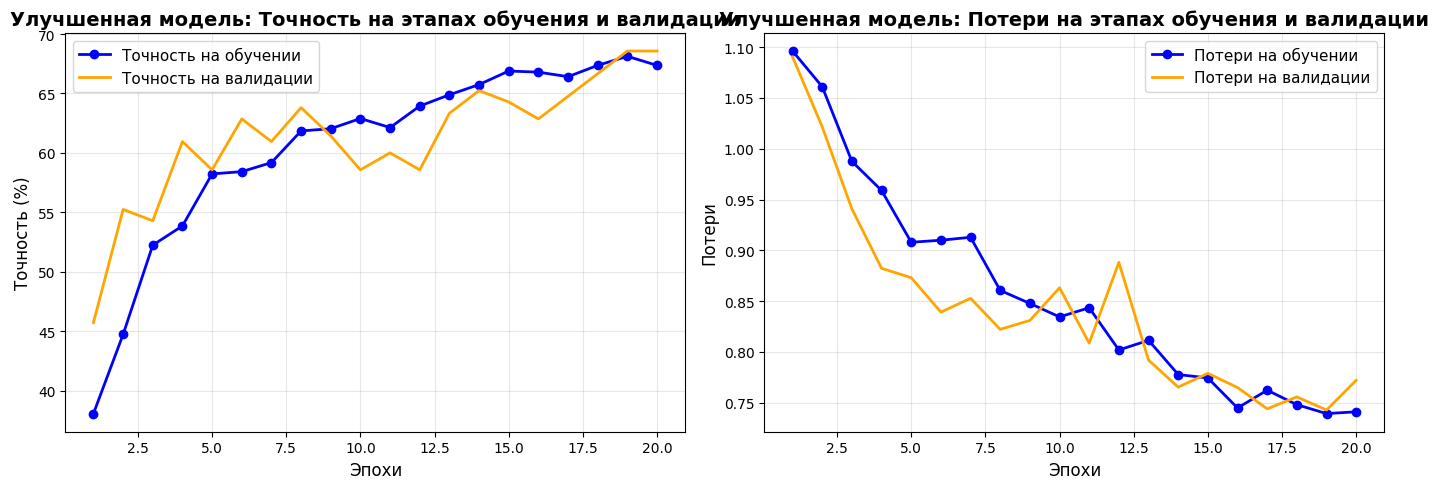


📊 IMPROVED MODEL TRAINING STATISTICS
Best Train Accuracy: 68.13% (Epoch 19)
Best Val Accuracy:   68.57% (Epoch 19)
Final Train Loss:    0.7411
Final Val Loss:      0.7721
✅ Good generalization! (gap: -1.21%)


In [24]:
# Extract data from improved model history
accuracy_improved = history_improved['train_acc']
val_accuracy_improved = history_improved['val_acc']
loss_improved = history_improved['train_loss']
val_loss_improved = history_improved['val_loss']
epochs_range_improved = range(1, len(accuracy_improved) + 1)

# Create figure with 2 subplots (side by side)
plt.figure(figsize=(14, 5))

# Plot 1: Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range_improved, accuracy_improved, 'bo-',
         label='Точность на обучении', linewidth=2, markersize=6)
plt.plot(epochs_range_improved, val_accuracy_improved, 'orange',
         label='Точность на валидации', linewidth=2)
plt.title('Улучшенная модель: Точность на этапах обучения и валидации',
         fontsize=14, fontweight='bold')
plt.xlabel('Эпохи', fontsize=12)
plt.ylabel('Точность (%)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Plot 2: Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range_improved, loss_improved, 'bo-',
         label='Потери на обучении', linewidth=2, markersize=6)
plt.plot(epochs_range_improved, val_loss_improved, 'orange',
         label='Потери на валидации', linewidth=2)
plt.title('Улучшенная модель: Потери на этапах обучения и валидации',
         fontsize=14, fontweight='bold')
plt.xlabel('Эпохи', fontsize=12)
plt.ylabel('Потери', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final statistics
print("\n" + "="*60)
print("📊 IMPROVED MODEL TRAINING STATISTICS")
print("="*60)
print(f"Best Train Accuracy: {max(accuracy_improved):.2f}% (Epoch {accuracy_improved.index(max(accuracy_improved))+1})")
print(f"Best Val Accuracy:   {max(val_accuracy_improved):.2f}% (Epoch {val_accuracy_improved.index(max(val_accuracy_improved))+1})")
print(f"Final Train Loss:    {loss_improved[-1]:.4f}")
print(f"Final Val Loss:      {val_loss_improved[-1]:.4f}")
print("="*60)

# Check for overfitting
train_val_gap_improved = accuracy_improved[-1] - val_accuracy_improved[-1]
if train_val_gap_improved > 15:
    print("⚠️  WARNING: Large gap between train and val accuracy!")
    print(f"   Gap: {train_val_gap_improved:.2f}%")
    print("   This indicates overfitting. Consider:")
    print("   - Using more data augmentation")
    print("   - Adding more dropout")
    print("   - Reducing model complexity")
elif train_val_gap_improved > 10:
    print(f"⚠️  Moderate overfitting detected (gap: {train_val_gap_improved:.2f}%)")
else:
    print(f"✅ Good generalization! (gap: {train_val_gap_improved:.2f}%)")
print("="*60)

In [25]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(model, test_dataset, device, start_idx=100, num_images=16):
    """
    Display model predictions on test images
    Shows images in 2 rows with predicted labels
    Green box = correct prediction
    Red box = wrong prediction

    Parameters:
    - model: trained PyTorch model
    - test_dataset: PyTorch Dataset object
    - device: 'cuda' or 'cpu'
    - start_idx: starting index in test set
    - num_images: how many images to show (default 16)
    """
    model.eval()  # Set to evaluation mode
    class_names = {0: 'Wavy', 1: 'Straight', 2: 'Dread'}

    # Collect predictions
    images_list = []
    labels_list = []
    predictions_list = []

    with torch.no_grad():
        for i in range(start_idx, start_idx + num_images):
            # Check if index is valid
            if i >= len(test_dataset):
                print(f"⚠️  Warning: Only {i - start_idx} images available from index {start_idx}")
                break

            # Get image and label from dataset
            image, true_label = test_dataset[i]
            images_list.append(image)
            labels_list.append(true_label)

            # Get prediction
            image_batch = image.unsqueeze(0).to(device)  # Add batch dimension
            output = model(image_batch)
            _, predicted = torch.max(output, 1)
            predictions_list.append(predicted.item())

    # Calculate number of rows and columns
    n_images = len(images_list)
    n_cols = 8
    n_rows = (n_images + n_cols - 1) // n_cols  # Ceiling division

    # Create figure
    plt.figure(figsize=(16, 2 * n_rows))

    for i in range(n_images):
        plt.subplot(n_rows, n_cols, i + 1)

        # Prepare image for display
        img_display = images_list[i].cpu().numpy()

        # If image is normalized, denormalize it
        # Check if values are in [-1, 1] or [0, 1]
        if img_display.min() < 0:
            # Denormalize from [-1, 1] to [0, 1]
            img_display = (img_display + 1) / 2

        # Convert from (C, H, W) to (H, W, C)
        img_display = img_display.transpose(1, 2, 0)

        # Clip values to [0, 1]
        img_display = np.clip(img_display, 0, 1)

        # Display image
        plt.imshow(img_display)

        # Get prediction and true label
        predicted_class = predictions_list[i]
        true_class = labels_list[i]
        label_text = class_names[predicted_class]

        # Color coding: green if correct, red if wrong
        if predicted_class == true_class:
            color = 'green'
            box_color = (0, 0.8, 0, 0.8)  # Green with transparency
        else:
            color = 'red'
            box_color = (1, 0, 0, 0.8)  # Red with transparency
            # Also show true label
            label_text = f'{label_text}\n(True: {class_names[true_class]})'

        # Add label with background box
        bbox_props = dict(boxstyle='round,pad=0.5',
                         facecolor=box_color,
                         edgecolor=color,
                         linewidth=2)

        plt.text(5, 15, label_text,
                color='white',
                fontsize=9,
                fontweight='bold',
                bbox=bbox_props,
                verticalalignment='top')

        plt.xticks([])
        plt.yticks([])
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Print statistics
    correct_predictions = sum([1 for p, t in zip(predictions_list, labels_list) if p == t])
    accuracy = 100 * correct_predictions / len(predictions_list)

    print(f"\n{'='*60}")
    print(f"📊 PREDICTION STATISTICS (Images {start_idx}-{start_idx + n_images - 1})")
    print(f"{'='*60}")
    print(f"   Total images: {n_images}")
    print(f"   Correct predictions: {correct_predictions}")
    print(f"   Wrong predictions: {n_images - correct_predictions}")
    print(f"   Accuracy: {accuracy:.2f}%")

    # Per-class statistics
    print(f"\n   Per-class breakdown:")
    for class_id, class_name in class_names.items():
        class_correct = sum([1 for p, t in zip(predictions_list, labels_list)
                           if p == t and t == class_id])
        class_total = sum([1 for t in labels_list if t == class_id])
        if class_total > 0:
            class_acc = 100 * class_correct / class_total
            print(f"   {class_name:10s}: {class_correct}/{class_total} correct ({class_acc:.1f}%)")

    print(f"{'='*60}\n")

print("✅ Visualization function created!")

✅ Visualization function created!


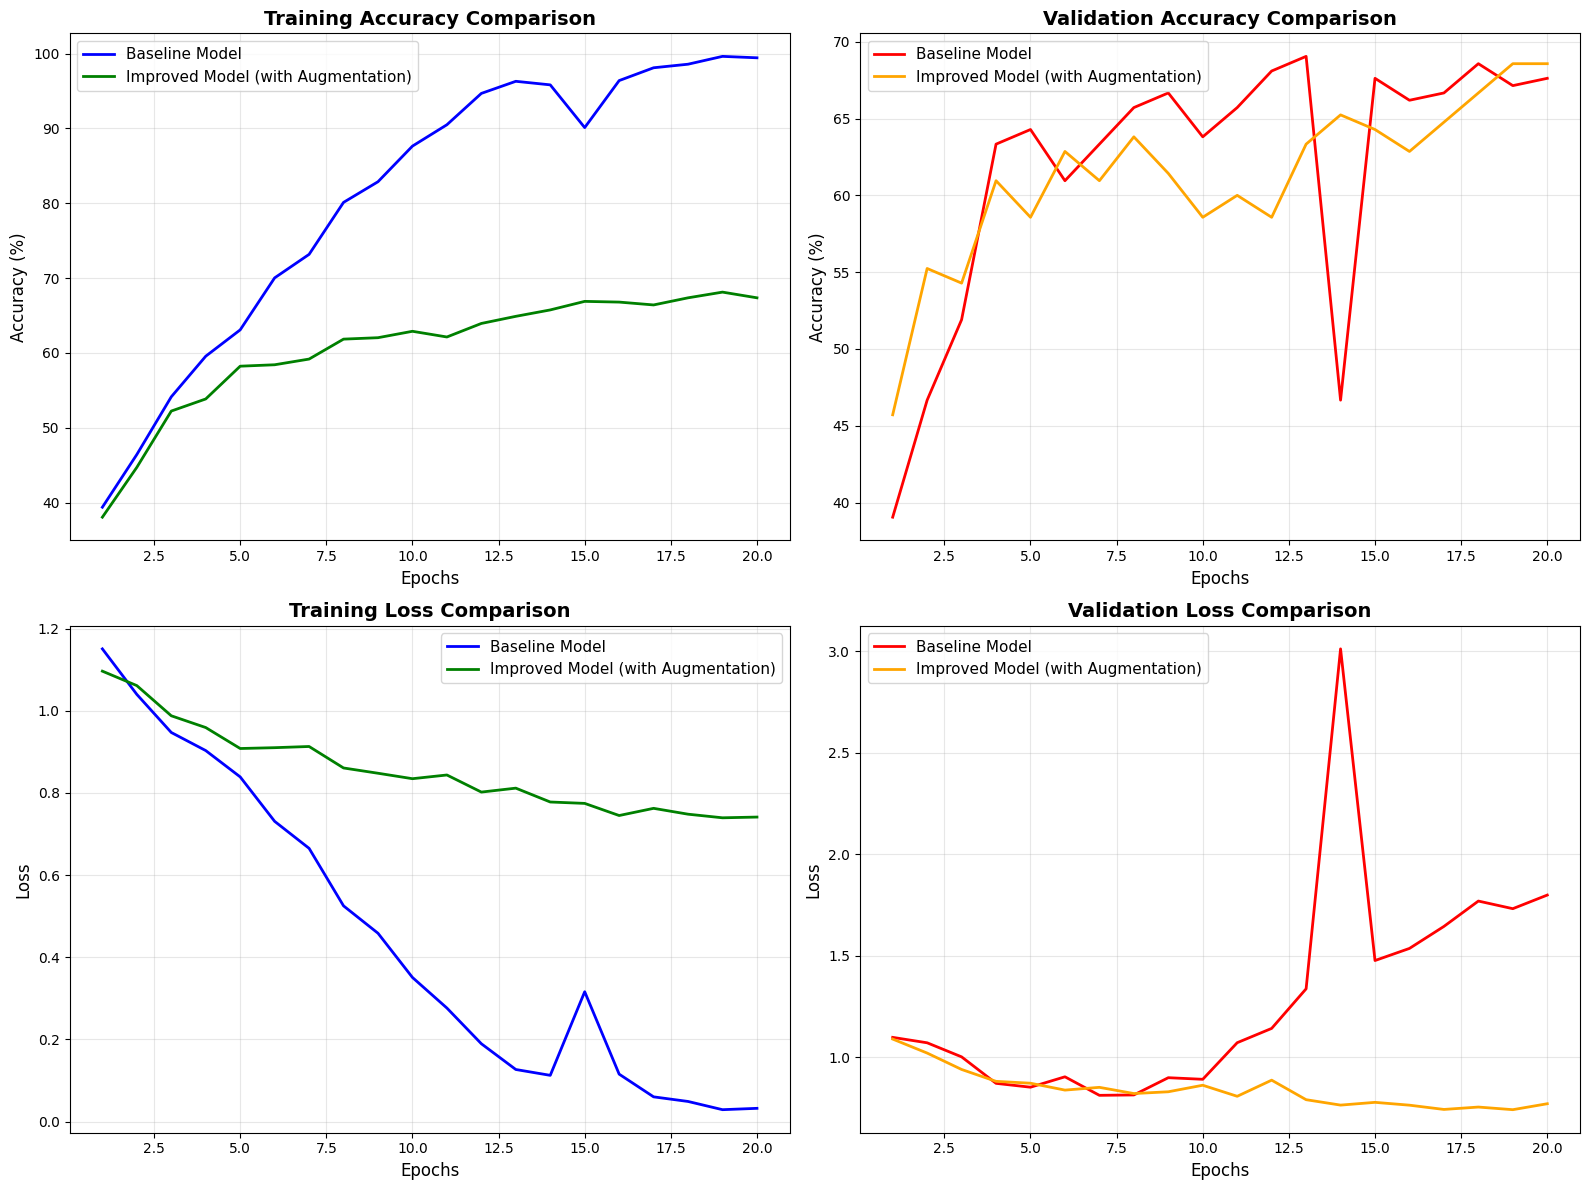


📊 DETAILED PERFORMANCE COMPARISON
Metric                              Baseline        Improved        Change
----------------------------------------------------------------------
Final Train Accuracy                 99.43%          67.36%         -32.06% ↓
Final Val Accuracy                   67.62%          68.57%         +0.95% ↑
Best Val Accuracy                    69.05%          68.57%         -0.48% ↓
Overfitting Gap                      31.81%          -1.21%         -33.02% ✅
Final Train Loss                    0.0323           0.7411
Final Val Loss                      1.7993           0.7721

📝 ANALYSIS:
⚠️  No improvement observed. Consider different augmentation strategies.
✅ Overfitting significantly reduced (gap decreased by 33.02%)

🎯 KEY IMPROVEMENTS IMPLEMENTED:
   • Data augmentation (flip, rotation, color jitter)
   • Batch normalization for training stability
   • Increased dropout for regularization
   • Deeper architecture (4 conv blocks)
   • Learning rate sche

In [26]:
# Compare baseline vs improved model
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

epochs_baseline = range(1, len(history['train_acc']) + 1)
epochs_improved = range(1, len(history_improved['train_acc']) + 1)

# Plot 1: Training Accuracy Comparison
axes[0, 0].plot(epochs_baseline, history['train_acc'], 'b-',
               label='Baseline Model', linewidth=2)
axes[0, 0].plot(epochs_improved, history_improved['train_acc'], 'g-',
               label='Improved Model (with Augmentation)', linewidth=2)
axes[0, 0].set_title('Training Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epochs', fontsize=12)
axes[0, 0].set_ylabel('Accuracy (%)', fontsize=12)
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Validation Accuracy Comparison
axes[0, 1].plot(epochs_baseline, history['val_acc'], 'r-',
               label='Baseline Model', linewidth=2)
axes[0, 1].plot(epochs_improved, history_improved['val_acc'], 'orange',
               label='Improved Model (with Augmentation)', linewidth=2)
axes[0, 1].set_title('Validation Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epochs', fontsize=12)
axes[0, 1].set_ylabel('Accuracy (%)', fontsize=12)
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Training Loss Comparison
axes[1, 0].plot(epochs_baseline, history['train_loss'], 'b-',
               label='Baseline Model', linewidth=2)
axes[1, 0].plot(epochs_improved, history_improved['train_loss'], 'g-',
               label='Improved Model (with Augmentation)', linewidth=2)
axes[1, 0].set_title('Training Loss Comparison', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epochs', fontsize=12)
axes[1, 0].set_ylabel('Loss', fontsize=12)
axes[1, 0].legend(fontsize=11)
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Validation Loss Comparison
axes[1, 1].plot(epochs_baseline, history['val_loss'], 'r-',
               label='Baseline Model', linewidth=2)
axes[1, 1].plot(epochs_improved, history_improved['val_loss'], 'orange',
               label='Improved Model (with Augmentation)', linewidth=2)
axes[1, 1].set_title('Validation Loss Comparison', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epochs', fontsize=12)
axes[1, 1].set_ylabel('Loss', fontsize=12)
axes[1, 1].legend(fontsize=11)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Detailed comparison table
print("\n" + "="*70)
print("📊 DETAILED PERFORMANCE COMPARISON")
print("="*70)
print(f"{'Metric':<35} {'Baseline':<15} {'Improved':<15} {'Change'}")
print("-" * 70)

# Training accuracy
orig_train_acc = history['train_acc'][-1]
impr_train_acc = history_improved['train_acc'][-1]
change = impr_train_acc - orig_train_acc
symbol = "↑" if change > 0 else "↓"
print(f"{'Final Train Accuracy':<35} {orig_train_acc:>6.2f}%{'':<8} {impr_train_acc:>6.2f}%{'':<8} {change:+.2f}% {symbol}")

# Validation accuracy
orig_val_acc = history['val_acc'][-1]
impr_val_acc = history_improved['val_acc'][-1]
change = impr_val_acc - orig_val_acc
symbol = "↑" if change > 0 else "↓"
print(f"{'Final Val Accuracy':<35} {orig_val_acc:>6.2f}%{'':<8} {impr_val_acc:>6.2f}%{'':<8} {change:+.2f}% {symbol}")

# Best validation accuracy
orig_best_val = max(history['val_acc'])
impr_best_val = max(history_improved['val_acc'])
change = impr_best_val - orig_best_val
symbol = "↑" if change > 0 else "↓"
print(f"{'Best Val Accuracy':<35} {orig_best_val:>6.2f}%{'':<8} {impr_best_val:>6.2f}%{'':<8} {change:+.2f}% {symbol}")

# Overfitting gap
orig_gap = history['train_acc'][-1] - history['val_acc'][-1]
impr_gap = history_improved['train_acc'][-1] - history_improved['val_acc'][-1]
change = impr_gap - orig_gap
symbol = "✅" if change < 0 else "⚠️"
print(f"{'Overfitting Gap':<35} {orig_gap:>6.2f}%{'':<8} {impr_gap:>6.2f}%{'':<8} {change:+.2f}% {symbol}")

# Final losses
orig_train_loss = history['train_loss'][-1]
impr_train_loss = history_improved['train_loss'][-1]
print(f"{'Final Train Loss':<35} {orig_train_loss:>6.4f}{'':<10} {impr_train_loss:>6.4f}")

orig_val_loss = history['val_loss'][-1]
impr_val_loss = history_improved['val_loss'][-1]
print(f"{'Final Val Loss':<35} {orig_val_loss:>6.4f}{'':<10} {impr_val_loss:>6.4f}")

print("="*70)

# Analysis
print("\n📝 ANALYSIS:")
val_improvement = impr_best_val - orig_best_val
if val_improvement > 5:
    print(f"✅ Significant improvement! Validation accuracy increased by {val_improvement:.2f}%")
elif val_improvement > 0:
    print(f"✅ Moderate improvement. Validation accuracy increased by {val_improvement:.2f}%")
else:
    print(f"⚠️  No improvement observed. Consider different augmentation strategies.")

gap_change = impr_gap - orig_gap
if gap_change < -5:
    print(f"✅ Overfitting significantly reduced (gap decreased by {abs(gap_change):.2f}%)")
elif gap_change < 0:
    print(f"✅ Overfitting slightly reduced (gap decreased by {abs(gap_change):.2f}%)")
else:
    print(f"⚠️  Overfitting increased by {gap_change:.2f}%")

print("\n🎯 KEY IMPROVEMENTS IMPLEMENTED:")
print("   • Data augmentation (flip, rotation, color jitter)")
print("   • Batch normalization for training stability")
print("   • Increased dropout for regularization")
print("   • Deeper architecture (4 conv blocks)")
print("   • Learning rate scheduler")
print("="*70)